In [197]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
from jax.lax import fori_loop
from jax import jit
from functools import partial

import math


import scipy 

import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

HOME = "/Users/daniellengyel/curr_adventure/exact_sampling/"

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter, Ackley
from RBF import RBF
from utils import mse_sensitivity, get_rbfs


from DynamicalSystems import Laser, LaserFull, Monod, invert_Laser_params, Cancer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
def ratio_plot(func_name, sig, num_MC, res_fd, res_cfd, res_ours, res_rbf):
    plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)
    plt.xlabel("$log_2$ Ratio")
    plt.ylabel("Count")
    plt.savefig(HOME + "SensitivityAnalysis/Figures/sig_{}_num_{}_{}_rbf.pdf".format(sig, num_MC, func_name))
    plt.show()
    
    plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)
    plt.xlabel("$log_2$ Ratio")
    plt.ylabel("Count")
    plt.savefig(HOME + "SensitivityAnalysis/Figures/sig_{}_num_{}_{}_fd.pdf".format(sig, num_MC, func_name))
    plt.show()
    
    plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)
    plt.xlabel("$log_2$ Ratio")
    plt.ylabel("Count")
    plt.savefig(HOME + "SensitivityAnalysis/Figures/sig_{}_num_{}_{}_cfd.pdf".format(sig, num_MC, func_name))
    plt.show()

# Compare against true Hessian (so optimal benefit we can obtain) to some coarse model. 

# Ackley

In [200]:
dim = 32 
sig = 1e-3

prmts_0 = jnp.zeros(dim)

F = Ackley()
F_tilde = Ackley(sig)
            

prct_bound = 0.2 # we look at a neighborhood of +/- p%. 
fixed_bound = 1
jrandom_key = jrandom.PRNGKey(0)




In [201]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([F], prmts_0, N_pts, prct_bound, subkey, fixed_bound=fixed_bound, smoothing=0)
    

100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 879.65it/s]


In [202]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e2)
pts = prmts_0.reshape(1, len(prmts_0)) + fixed_bound*(jrandom.uniform(subkey, shape=(N_pts, len(prmts_0))) - 0.5)*2
h_space = jnp.logspace(-1, -6, 6)

num_MC = 1

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(F, F_tilde, sig, pts, rbfs[0], h_space, subkey, num_runs=num_MC)


100%|█████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


In [207]:
res_fd.shape

AttributeError: 'list' object has no attribute 'shape'

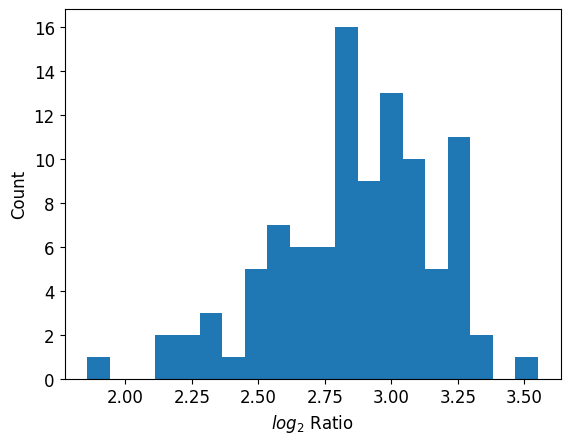

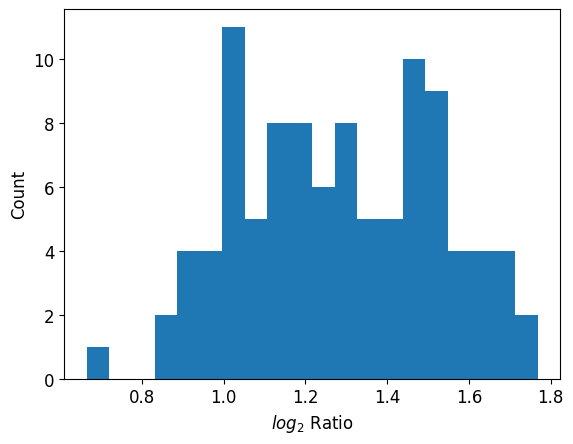

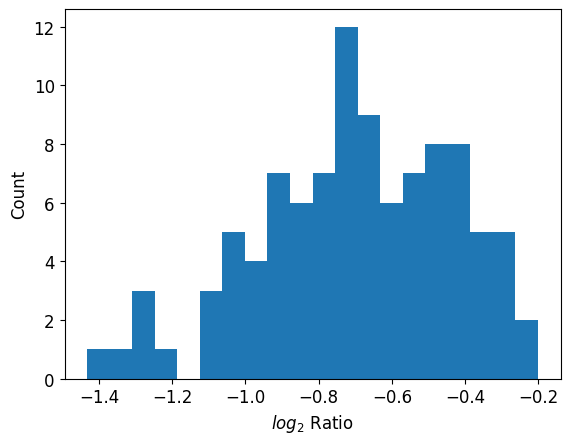

In [206]:
ratio_plot("Ackley", sig, num_MC, res_fd, res_cfd, res_ours, res_rbf)

In [ ]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = 1
pts = prmts_0.reshape(1, len(prmts_0)) + fixed_bound*(jrandom.uniform(subkey, shape=(N_pts, len(prmts_0))) - 0.5)*2
h_space = jnp.logspace(-1, -6, 6)

num_MC = 1

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(F, F_tilde, sig, pts, rbfs[0], h_space, subkey, num_runs=num_MC)



# Cancer

In [160]:
a1 = 0.1
a2 = 0.3
a3 = 0.69
b1 = 0.1
b2 = 0.3
b3 = 0.397
gamma = 0.139
k0 = 0.1
m0 = 0.1
k1 = 0.0003
m1 = 0.0004

final_T = 100
dt = 0.01

x_init = 1
y_init = 100
z_init = 100

prmts_0 = jnp.array([a1, a2, a3, b1, b2, b3, gamma, k0, m0, k1, m1])

Fs = [Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N0"),
      Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N1"),
      Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N2")]

sig = 1e-3
Fs_tilde = [Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N0"),
            Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N1"),
            Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N2")]
            

prct_bound = 0.1 # we look at a neighborhood of +/- p%. 
jrandom_key = jrandom.PRNGKey(0)




In [163]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([Fs[0]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4181.73it/s]


In [192]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e2)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, len(prmts_0))) - 0.5)*2
pts = prmts_0.reshape(1, len(prmts_0))*(1 + pts_prct)
h_space = jnp.logspace(-2, -3.5, 6)
true_h = 1e-11

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[0], Fs_tilde[0], sig, pts, rbfs[0], h_space, subkey, true_h=true_h, num_runs=10)




100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


(array([ 2., 11., 15., 24., 11.,  5., 10.,  4.,  3.,  4.,  2.,  0.,  0.,
         1.,  3.,  2.,  1.,  0.,  0.,  2.]),
 array([0.62676629, 0.74354731, 0.86032833, 0.97710935, 1.09389037,
        1.21067139, 1.32745241, 1.44423344, 1.56101446, 1.67779548,
        1.7945765 , 1.91135752, 2.02813854, 2.14491956, 2.26170058,
        2.3784816 , 2.49526262, 2.61204364, 2.72882466, 2.84560568,
        2.9623867 ]),
 <BarContainer object of 20 artists>)

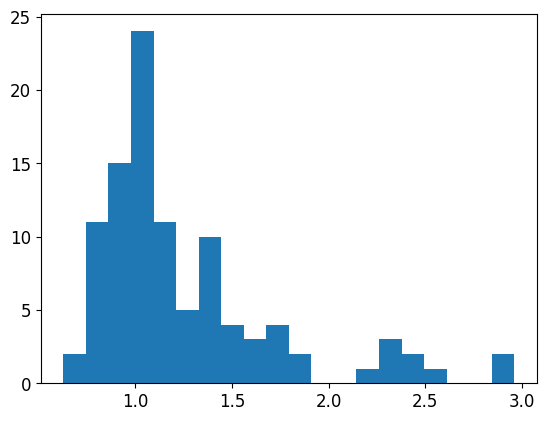

In [193]:
plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  0.,  2.,  0.,  0.,  1.,  1.,  2.,  8.,  6.,  8., 12., 10.,
        13., 18.,  5.,  6.,  5.,  1.,  1.]),
 array([0.9284893 , 0.99147442, 1.05445954, 1.11744467, 1.18042979,
        1.24341492, 1.30640004, 1.36938516, 1.43237029, 1.49535541,
        1.55834053, 1.62132566, 1.68431078, 1.7472959 , 1.81028103,
        1.87326615, 1.93625128, 1.9992364 , 2.06222152, 2.12520665,
        2.18819177]),
 <BarContainer object of 20 artists>)

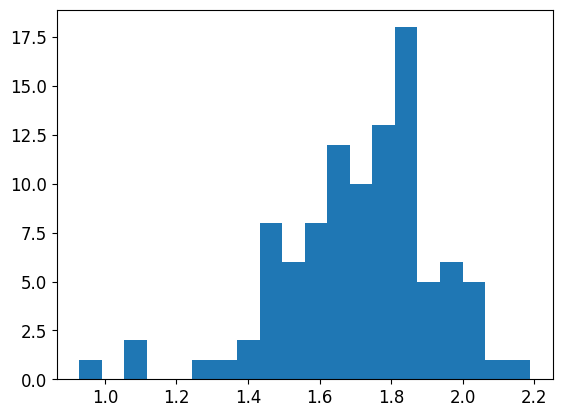

In [194]:
plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  2.,  0.,  0.,  0.,  1.,  5.,  4.,  3.,  8., 11., 17., 10.,
        19.,  9.,  7.,  1.,  0.,  1.,  1.]),
 array([-0.99096636, -0.92977127, -0.86857617, -0.80738108, -0.74618599,
        -0.68499089, -0.6237958 , -0.5626007 , -0.50140561, -0.44021051,
        -0.37901542, -0.31782032, -0.25662523, -0.19543013, -0.13423504,
        -0.07303994, -0.01184485,  0.04935025,  0.11054534,  0.17174043,
         0.23293553]),
 <BarContainer object of 20 artists>)

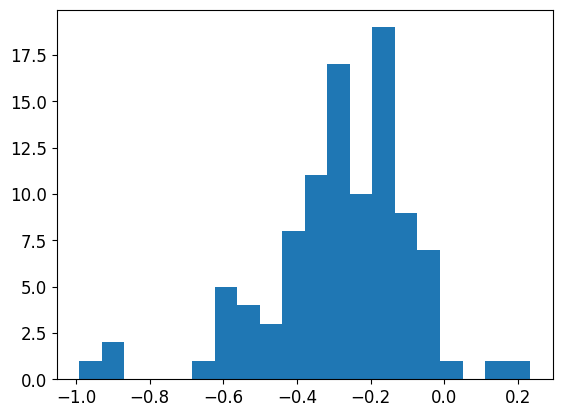

In [195]:
plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)